# Introduction
This notebook will handle a denoising autoencoder on the MNIST-dataset.

# Imports

In [148]:
import sys
assert sys.version_info >= (3,5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

import tensorflow as tf
from tensorflow import keras
from tensorflow import image
from tensorflow import core
from tensorflow.keras import layers

assert tf.__version__ >= "2.0"

print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ",keras.__version__)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")


tf.random.set_seed(42)
np.random.seed(42)
random_state=42

kaggle = 0 # Kaggle path active = 1

# change your local path here
if kaggle == 1 :
    MNIST_PATH= '../input/digit-recognizer'
else:
    MNIST_PATH= '../autoencoding-mnist/data/input/digit-recognizer'



import os
for dirname, _, filenames in os.walk(MNIST_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Tensorflow Version:  2.3.0
Keras Version:  2.4.0
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
../autoencoding-mnist/data/input/digit-recognizer\keras_reg_160_10_002.sav
../autoencoding-mnist/data/input/digit-recognizer\keras_reg_jl_160_10_002.sav
../autoencoding-mnist/data/input/digit-recognizer\sample_submission.csv
../autoencoding-mnist/data/input/digit-recognizer\test.csv
../autoencoding-mnist/data/input/digit-recognizer\train.csv


## Get The Data

In [149]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'

def load_csv_data(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    return pd.read_csv(csv_path)

def load_csv_data_manuel(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data

def split_train_val(data, val_ratio):
    return 
    

train = load_csv_data(MNIST_PATH,CSV_FILE_TRAIN)
test = load_csv_data(MNIST_PATH,CSV_FILE_TEST)

### Train Val Split

In [150]:
X_train, X_valid, y_train, y_valid =  train_test_split(train.loc[:, train.columns != 'label'], train['label'], test_size=0.33, random_state=random_state)

### Preparing for Neural Network Structure

#### Datapipeline

In [151]:
# Pipeline for data transformation
####pipeline = Pipeline([
####    ('std_scalar', StandardScaler())
####    #('normalizer', Normalizer())
####])

In [152]:
X_train = X_train.astype(np.float32) / 255
X_valid = X_valid.astype(np.float32) / 255
X_test = test.astype(np.float32) / 255

In [153]:
X_train.shape


(28140, 784)

In [154]:
###X_train_prep = pipeline.fit_transform(X_train)
###X_valid_prep = pipeline.fit_transform(X_valid)

#### Reshaping Data in Tensor Batch Structure

In [155]:
X_train_resh = X_train.values.reshape(X_train.shape[0], 28, 28)
X_valid_resh = X_valid.values.reshape(X_valid.shape[0], 28, 28)

y_train_resh =  y_train.values.reshape(y_train.shape[0], 1)
y_valid_resh = y_valid.values.reshape(y_valid.shape[0], 1)

In [156]:
## DEBUG
#X_train_resh[2]

#X_train.iloc[:1]

X_train.astype(np.float32) / 255

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
38060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
X_valid_resh.shape

(13860, 28, 28)

# Plotting 

In [158]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, X_valid, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
    


In [159]:
y_valid.iloc[1]

1

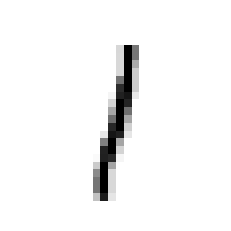

In [160]:
plot_image(X_valid.iloc[1].values.reshape(28,28))

# Model Creation - Deep Denoising Autoencoder

In [161]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")           # Codings
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),  ### PROBLEMSTELLE gefunden: Hier war relu drin
    keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))


In [162]:
dropout_encoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_9 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [163]:
dropout_decoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_11 (Dense)             (None, 784)               79184     
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


## Training 

In [164]:
history = dropout_ae.fit(X_train_resh, X_train_resh, epochs= 10, validation_data=(X_valid_resh, X_valid_resh))

Epoch 1/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2144 - val_loss: 0.1698
Epoch 2/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1519 - val_loss: 0.1420
Epoch 3/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1348 - val_loss: 0.1324
Epoch 4/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1278 - val_loss: 0.1264
Epoch 5/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1231 - val_loss: 0.1225
Epoch 6/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1201 - val_loss: 0.1203
Epoch 7/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1180 - val_loss: 0.1208
Epoch 8/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1164 - val_loss: 0.1180
Epoch 9/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1149 - val_loss: 0.1149
Epoch 10/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1137 - val_loss: 0.1142

### Losses

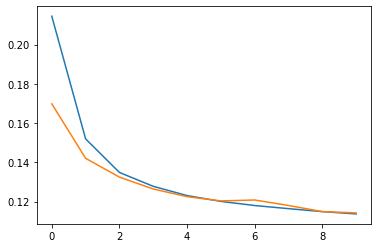

In [165]:
# Getting in touch with the model statistics 
# shows the available keys in models history:  print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Results

### Single Number Test - 6

#### Real Image

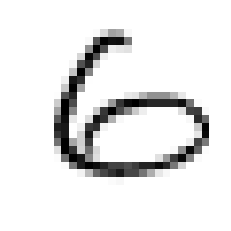

In [166]:
# Test image from a known set
plot_image(X_valid_resh[10])

#### ("Predicted") Autoencoded One

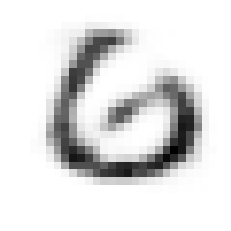

In [167]:

testimage = X_valid_resh[10].reshape(1, 28, 28)     # single image prepared for the test (reshape)
plot_image(dropout_ae.predict(testimage)[0, :, :])  # needed to extract the second and third array of the three dimensional tensor struc for printing the image


### Showing Multi Results

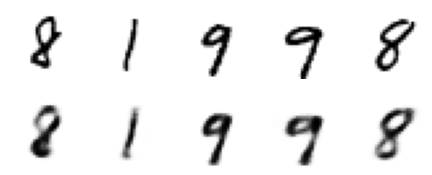

In [ ]:
show_reconstructions(dropout_ae, X_valid_resh)